## Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

## Overview

In [4]:
df = pd.read_csv('Dataset-Tugas.csv')
df.head(5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df['class'].value_counts()

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [6]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Pada kolom class memiliki 3 target, yaitu `Iris-sentosa`, `Iris-versicolor`, dan `Iris-virginica` yang masing-masing berjumlah 50. Karena masih dalam bentuk object, maka kita drop

In [7]:
df.drop(columns='class', inplace=True)

## Exploratory Data Analysis

In [8]:
df.shape

(150, 4)

Terdapat 150 column dan 4 tabel yang terdapat pada data ini

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


Semua kolom bertipe float64

In [10]:
df.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64

Tidak terdapat data yang kosong , sehingga kita tidak perlu melakukan handling missing values

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petal length,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petal width,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


Melihat statistik deskriptif dari dataset ini

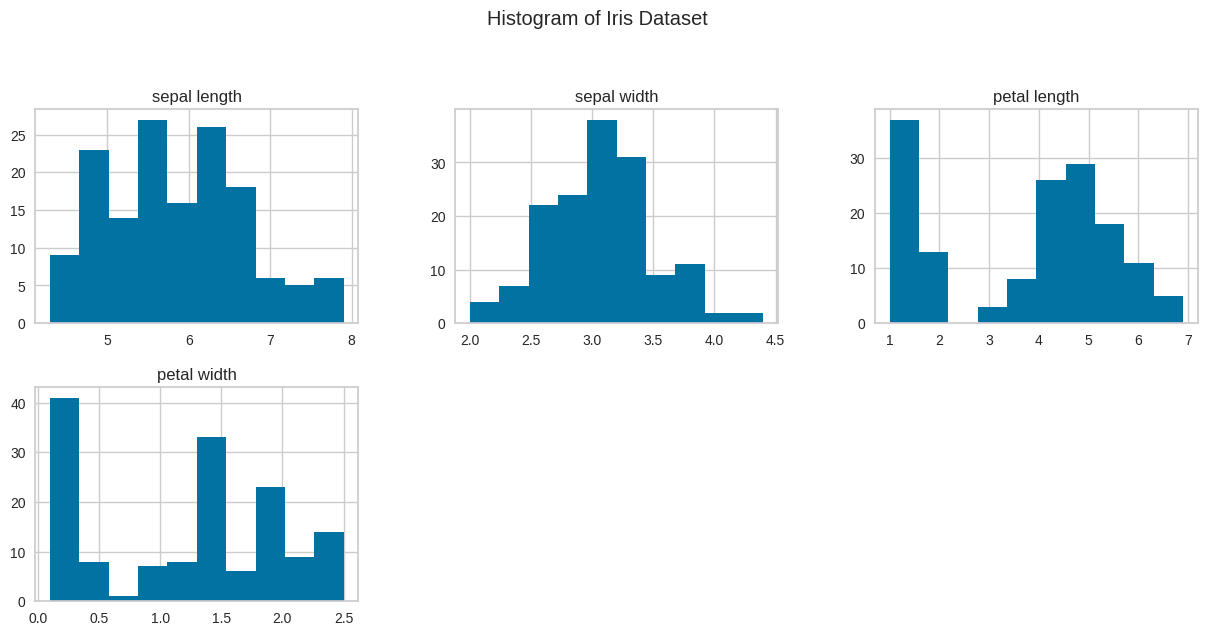

In [12]:
def plot_histograms(data):
    data.hist(bins=10, figsize=(15,10), layout=(3,3))
    plt.suptitle("Histogram of Iris Dataset")
    plt.show()

plot_histograms(df)

Dari histogram terlihat bahwa distribusi dari kolom tidak berdistribusi normal. Oleh karena itu, kita perlu lakukan normalisasi supaya skala datanya sama

In [13]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

outlier_counts = {}
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    outlier_counts[col] = count_outliers_iqr(df[col])

outliers_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outliers Count'])

outliers_counts_df

,Column,Outliers Count
0,sepal length,0
1,sepal width,4
2,petal length,0
3,petal width,0


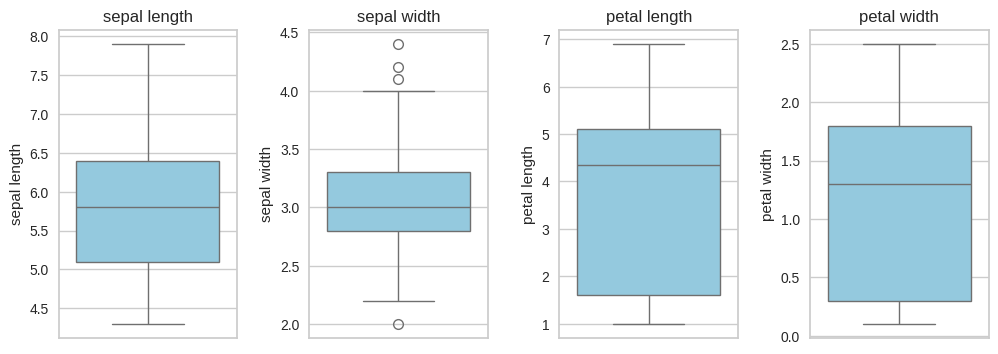

In [14]:
def box_plot(df):
  variables = df.select_dtypes(exclude = 'object').columns
  fig, axes = plt.subplots(1, 4, figsize = (12, 4)) 
  fig.subplots_adjust(hspace = 0.4, wspace = 0.4) 

  for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df, color = "skyblue", ax=axes[i])
    axes[i].set_title(var)

  plt.show()

box_plot(df)

Terlihat dari boxplot pada kolom `sepal width` terdapat outliers yang berjumlah 4. Bisa dilakukan handling outliers dengan di drop, namun dengan jumlah data yang sangat kecil maka akan kehilangan informasi yang berguna dan juga dari hasil statistik deskriptif jarak nilai Quartile 3 atau 75% dengan nilai maximum tidak terlalu jauh sehingga tidak perlu melakukan handling outliers

## Preprocessing

In [15]:
scaler = MinMaxScaler()

x = scaler.fit_transform(df)

Menggunakan MinMaxScaler karena akan mengubah skala datanya menjadi range 0 - 1

## Modelling

### K-Means

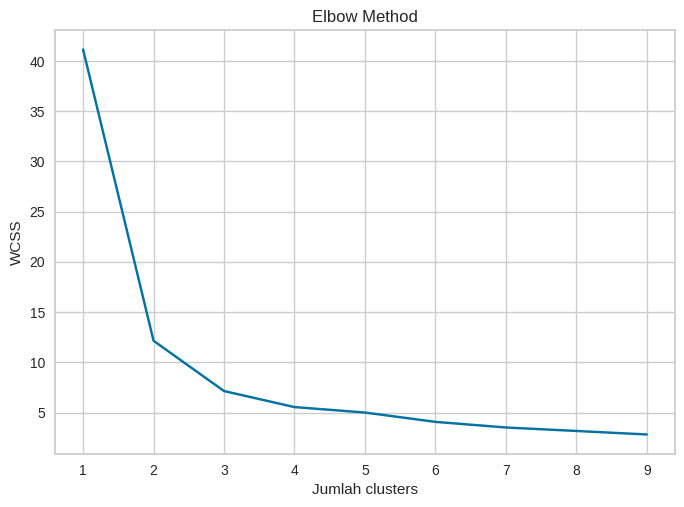

In [16]:
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Jumlah clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method merupakan pendekatan yang mencari titik dimana penurunan inersia mulai melambat, membentuk grafik yang merupai bentuk elbow. Inersia mengukur seberapa dekat titik-titik data dengan pusat cluster. Pengukuran inersia dilakukan dengan menggunakan **Within-Cluster Sum of Squares (WCSS)**. Penentuan jumlah cluster didasarkan pada penurunan inersia pada grafik. Dari elbow method diatas jumlah cluster optimal yang bisa digunakan yaitu 2 cluster atau 3 cluster, karena terlihat penurunan inersia yang mulai melambat pada cluster 2 atau 3

In [17]:
km2 = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_pred_km2 = km2.fit_predict(x)

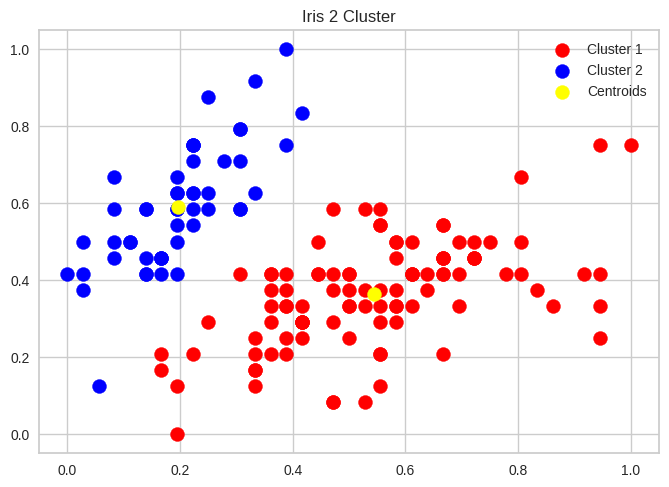

In [18]:
plt.scatter(x[y_pred_km2 == 0, 0], x[y_pred_km2 == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(x[y_pred_km2 == 1, 0], x[y_pred_km2 == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(km2.cluster_centers_[:, 0], km2.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Iris 2 Cluster')
plt.legend()
plt.show()

In [19]:
df['Label_K-Means2'] = km2.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [35]:
df['Label_K-Means2'].value_counts()

Label_K-Means2
0    100
1     50
Name: count, dtype: int64

In [20]:
km = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_pred_km = km.fit_predict(x)

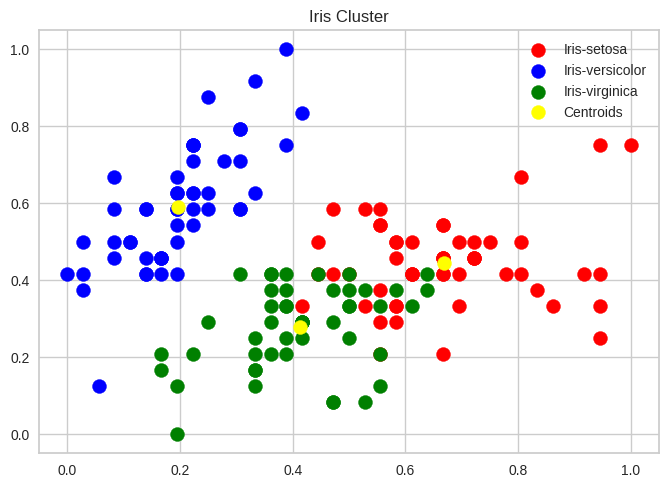

In [21]:
plt.scatter(x[y_pred_km == 0, 0], x[y_pred_km == 0, 1], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_pred_km == 1, 0], x[y_pred_km == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolor')
plt.scatter(x[y_pred_km == 2, 0], x[y_pred_km == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Iris Cluster')
plt.legend()
plt.show()

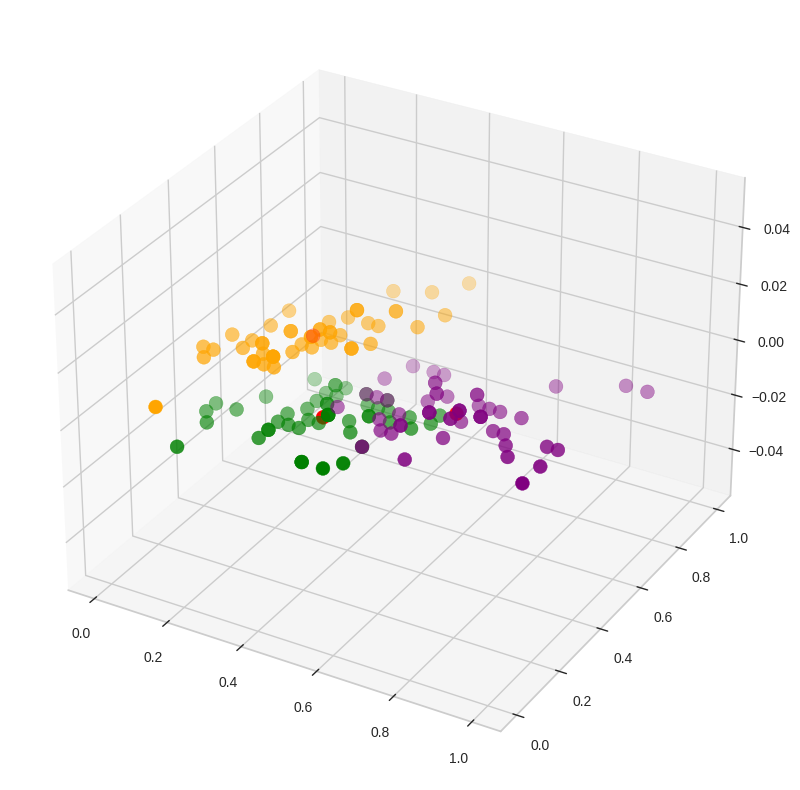

In [37]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x[y_pred_km == 0, 0], x[y_pred_km == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(x[y_pred_km == 1, 0], x[y_pred_km == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(x[y_pred_km == 2, 0], x[y_pred_km == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.show()

In [22]:
df['Label_K-Means'] = km.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2,Label_K-Means
0,5.1,3.5,1.4,0.2,1,1
1,4.9,3.0,1.4,0.2,1,1
2,4.7,3.2,1.3,0.2,1,1
3,4.6,3.1,1.5,0.2,1,1
4,5.0,3.6,1.4,0.2,1,1


In [23]:
df['Label_K-Means'].value_counts()

Label_K-Means
0    52
1    50
2    48
Name: count, dtype: int64

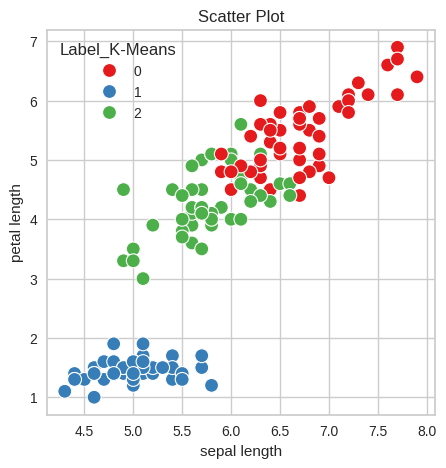

In [24]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'sepal length', y = 'petal length', hue = 'Label_K-Means', data = df, palette = 'Set1', s=100);
plt.title("Scatter Plot")
plt.show()

### DBSCAN

In [25]:
db = DBSCAN(eps=0.4, min_samples=5)
db.fit(x)

y_pred_db = db.labels_

In [27]:
df['Label_DB-Scan'] = db.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2,Label_K-Means,Label_DB-Scan
0,5.1,3.5,1.4,0.2,1,1,0
1,4.9,3.0,1.4,0.2,1,1,0
2,4.7,3.2,1.3,0.2,1,1,0
3,4.6,3.1,1.5,0.2,1,1,0
4,5.0,3.6,1.4,0.2,1,1,0


In [28]:
df['Label_DB-Scan'].value_counts()

Label_DB-Scan
1    100
0     50
Name: count, dtype: int64

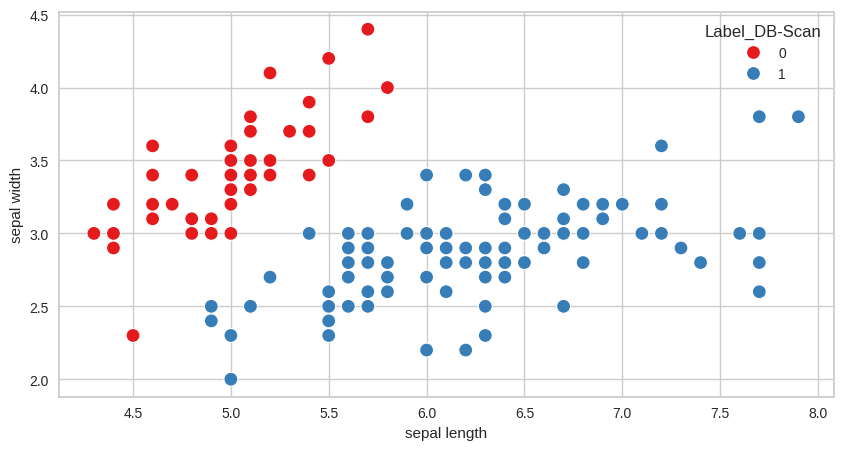

In [29]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'sepal length', y = 'sepal width', hue = 'Label_DB-Scan', data = df, palette = 'Set1', s=100);

## Evaluation

### K-Means

In [30]:
e_km2 = silhouette_score(x, y_pred_km2)
dbi_km2 = davies_bouldin_score(x, y_pred_km2)

print('Silhouette Score K-Means 2 Cluster:', e_km2)
print('Davies-Bouldin Index K-Means 2 Cluster:', dbi_km2)

Silhouette Score K-Means 2 Cluster: 0.6294675561906644
Davies-Bouldin Index K-Means 2 Cluster: 0.48770481288357487


Silhouette Score mengukur seberapa baik setiap titik data dalam cluster tertentu ditempatkan dan sejauh mana titik data tersebut berada dari cluster tetangga terdekatnya. Silhoutte Score berada pada -1 sampai 1. Nilai positif menunjukan bahwa titik data lebih dekat dengan clusternya sendiri daripada cluster tetangga dekatnya. Sedangkan nilai negatif menunjukan sebaliknya, yaitu bahwa titik data mungkin ditempatkan pada cluster yang salah. Nilai 0 menunjukan bahwa titik data berada di dekat batas antara dua cluster. Silhoutte Score positif yang tinggi menunjukan bahwa objek berada dalam cluster yang sesuai. Dari hasil Silhoutte Score menggunakan K-Means 2 cluster dapat dilihat mendapat score 0.62 yang menunjukan nilai yang baik karena cluster dapat terpisah dengan baik dan jelas.

Davies-Bouldin Index menghitung rata-rata nilai setiap titik pada himpunan data. Perhitungan nilai setiap titik adalah jumlah nilai compactness yang dibagi dengan jarak antara kedua titik pusat klaster sebagai separation. Jumlah klaster terbaik ditunjukkan dengan nilai DB yang semakin kecil (Davies & Bouldin, 1979). Dari hasil pengukuran menggunakan Davies-Bouldin Index diatas menunjukan hasil yang cukup optimal yang mengindikasikan bahwa cluster memiliki separasi yang cukup jelas

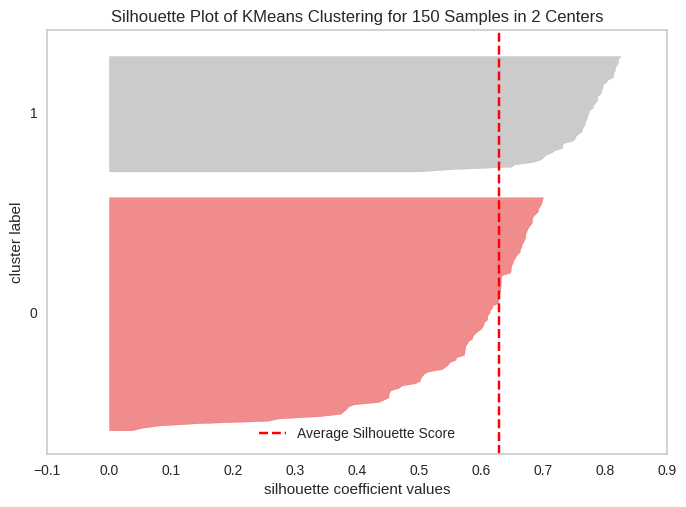

In [31]:
silhouette_viz = SilhouetteVisualizer(km2)
silhouette_viz.fit(x)
plt.grid(False)
silhouette_viz.show()
plt.show()

Dari grafik diatas, cluster 1 dan 0 memiliki lebar yang berbeda yang menandakan kedua cluster tersebut memiliki jumlah anggota yang tidak sama. Sebagian besar data memiliki score silhouette coefficient positif, menandakan bahwa data berada lebih dekat dengan clusternya sendiri daripada cluster lain. Namun terdapat beberapa nilai yang mendekati nol yang menandakan bahwa data tersebut berada di perbatasan antara dua cluster. Tidak ditemukan score silhouette coefficient negatif yang berarti tidak ada data yang lebih dekat ke cluster lain daripada cluster sendiri.

In [32]:
e_km = silhouette_score(x, y_pred_km)
dbi_km = davies_bouldin_score(x, y_pred_km)

print('Silhouette Score K-Means 3 Cluster:', e_km)
print('Davies-Bouldin Index K-Means 3 Cluster 3:', dbi_km)

Silhouette Score K-Means 3 Cluster: 0.48247222154221125
Davies-Bouldin Index K-Means 3 Cluster 3: 0.7874978912757878


Nilai Silhouette Score sebesar 0.482 menandakan kualitas clustering yang cukup meskipun tidak optimal. Score tersebut menunjukan separasi antar cluster tidak terlalu jelas jika dibandingkan dengan clustering sebelumnya menggunakan 2 cluster. Score Davies-Bouldin Index 3 cluster yang sebesar 0.787 menunjukan score lebih tinggi daripada nilai pada clustering dengan 2 cluster yang menunjukan bahwa cluster lebih tumpang tindih dan kurang terpisah secara signifikan

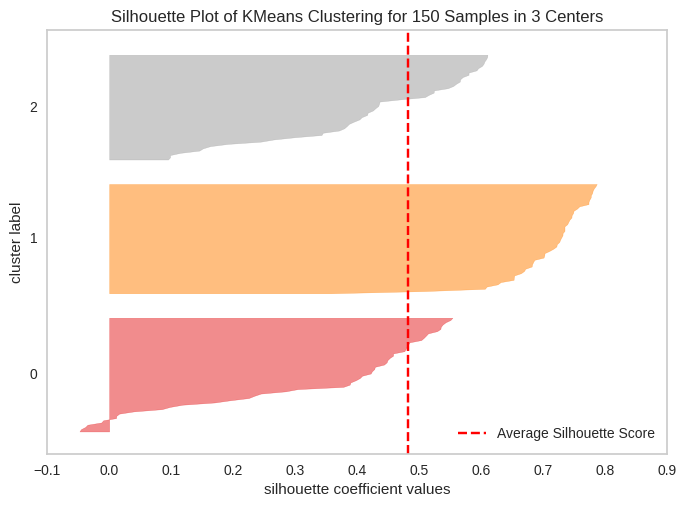

In [33]:
silhouette_viz = SilhouetteVisualizer(km)
silhouette_viz.fit(x)
plt.grid(False)
silhouette_viz.show()
plt.show()

Dari gambar visualisasi diatas, terlihat bahwa variasi dalam lebar cluster yang menandakan jumlah anggota di setiap cluster tidak seimbang. Beberapa data dalam cluster memiliki silhouette score coefficient yang mendekati nol, yang menunjukkan bahwa data berada di batas antara dua cluster. Selain itu ada data dengan nilai negatif yang menunjukan ada beberapa data dikelompokkan ke cluster yang salah karena jaraknya lebih dekat dengan cluster lain.

### DBSCAN

In [34]:
e_db = silhouette_score(x, y_pred_db)
dbi_db = davies_bouldin_score(x, y_pred_db)

print('Silhouette Score DBSCAN:', e_db)
print('Davies-Bouldin Index DBSCAN:', dbi_db)

Silhouette Score DBSCAN: 0.6294675561906644
Davies-Bouldin Index DBSCAN: 0.48770481288357487


Sama seperti hasil 2 cluster menggunakan K-Means, silhouette score berada di angka 0.62 yang menunjukan hasil yang cukup baik  karena cluster dapat terpisah dengan baik dan jelas. Sedangkan untuk Davies-Bouldin Index menggunakan DBSCAN dengan memperoleh score 0.48 menunjukan hasil yang cukup optimal yang mengindikasikan bahwa cluster memiliki separasi yang cukup jelas.